### Importing Packages

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Importing the Dataset

The Quora Question Pairs dataset was uploaded to Google Drive, and the drive was mounted to Colab.

In [2]:
df = pd.read_csv('/content/drive/MyDrive/ay2324 sem1/cs3244/project/train.csv')

In [3]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [5]:
num_samples = len(df)
num_samples

404290

### Checking for Class Imbalance

In [11]:
pos_class_count = len(df[df['is_duplicate'] == 1])
neg_class_count = num_samples - pos_class_count

pos_percentage = (pos_class_count / num_samples) * 100
neg_percentage = (neg_class_count / num_samples) * 100

print(f'Number of question pairs classified as duplicate: {pos_class_count}, ({pos_percentage:.2f}%)')
print(f'Number of question pairs classified as not duplicate: {neg_class_count}, ({neg_percentage:.2f}%)')

Number of question pairs classified as duplicate: 149263, (36.92%)
Number of question pairs classified as not duplicate: 255027, (63.08%)


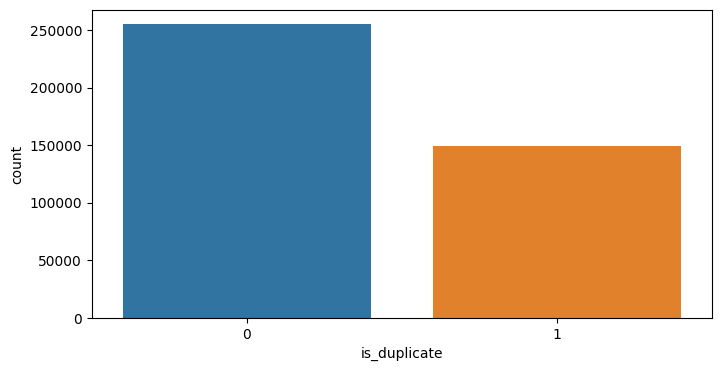

In [21]:
plt.figure(figsize=(8, 4))
sns.countplot(x='is_duplicate', data=df)
plt.xlabel('is_duplicate')
plt.ylabel('count')

plt.show()

### Word Count Analysis

I think this might help in determining the neural network architecture to use? The max question length is around 200 which might not work well if we are using RNNs, i.e. RNNs generally work well for shorter sequences.

Transformers ftw!!!

In [12]:
df_copy = df.copy()

Min word count for question 1: 1
Min word count for question 2: 1
Max word count for question 1: 125
Max word count for question 2: 237


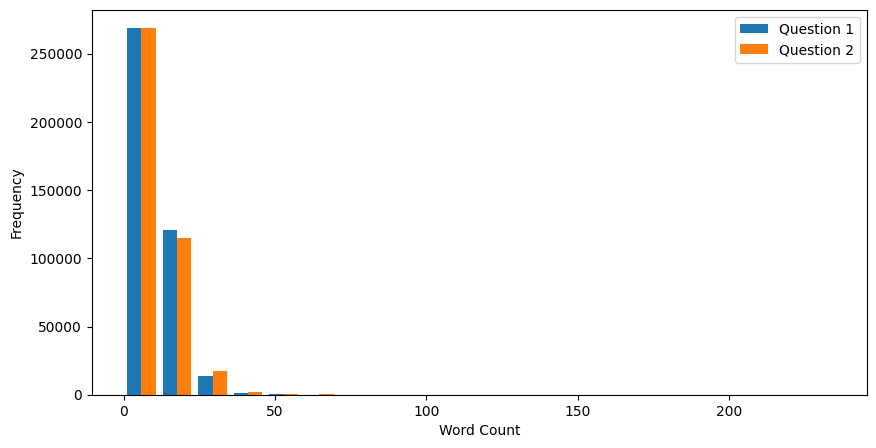

In [34]:
# find word counts of questions
df_copy['question1_word_count'] = df_copy['question1'].apply(lambda x: len(str(x).split()))
df_copy['question2_word_count'] = df_copy['question2'].apply(lambda x: len(str(x).split()))

print(f"Min word count for question 1: {df_copy['question1_word_count'].min()}")
print(f"Min word count for question 2: {df_copy['question2_word_count'].min()}")

print(f"Max word count for question 1: {df_copy['question1_word_count'].max()}")
print(f"Max word count for question 2: {df_copy['question2_word_count'].max()}")

plt.figure(figsize=(10, 5))
plt.hist([df_copy['question1_word_count'], df_copy['question2_word_count']], bins=20, label=['Question 1', 'Question 2'], range=(0, 235))
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend()

In [36]:
word_count_bins = 20  # This should match the number of bins used in your histogram
hist, bin_edges = np.histogram(df_copy['question1_word_count'], bins=word_count_bins)

bin_with_highest_freq = bin_edges[np.argmax(hist)]
bin_with_lowest_freq = bin_edges[np.argmin(hist)]
print(f"Word count with the highest frequency: {bin_with_highest_freq:1f}")
print(f"Word count with the lowest frequency: {bin_with_lowest_freq:1f}")

Word count with the highest frequency: 7.200000
Word count with the lowest frequency: 81.600000


### Word Frequency Analysis

Determine how many tokens we need. The data here is not cleaned yet so we might need much less tokens.

In [39]:
word_frequency = df['question1'].str.cat(sep=' ').split() + df['question2'].str.cat(sep=' ').split()
word_freq_dict = pd.Series(word_frequency).value_counts()

In [42]:
num_words = len(word_freq_dict)
print(f"Number of unique words/tokens: {num_words}")

Number of unique words/tokens: 232533


In [40]:
word_freq_dict.head(10)  # 10 most common words

the     371820
What    292717
is      216145
I       211499
a       208427
to      203403
How     201445
in      190010
of      158564
do      139461
dtype: int64

In [46]:
word_freq_dict.tail(10) # least common words

Singaporean)      1
burpees?          1
palindromic?      1
2017-18           1
Lnmiit            1
LS990?            1
'boob'            1
indeed.com?       1
mastubate         1
Homosexuality?    1
dtype: int64

### Checking for Correlation / Potential Features

Check if there is a correlation between question having the same lengths and the question pair being a duplicate

There doesn't seem to be a correlation, so the `question_length_diff` feature may not be too useful.

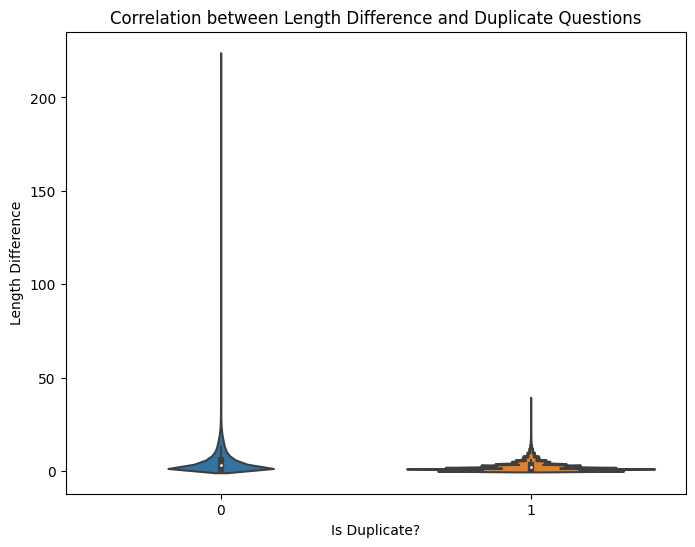

In [55]:
df_copy['question_length_diff'] = abs(df_copy['question1_word_count'] - df_copy['question2_word_count'])

plt.figure(figsize=(8, 6))
sns.violinplot(x='is_duplicate', y='question_length_diff', data=df_copy)
plt.xlabel('Is Duplicate?')
plt.ylabel('Length Difference')
plt.title('Correlation between Length Difference and Duplicate Questions')
plt.show()

In [53]:
correlation_coefficient = df_copy['question_length_diff'].corr(df_copy['is_duplicate'])
print(f"Point-Biserial Correlation Coefficient: {correlation_coefficient}")

Point-Biserial Correlation Coefficient: -0.20152626523656483


### **Haven't tried out:** Data Cleaning

Haven't ran the code below as I am unsure if it would be correct

In [56]:
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993224 sha256=296bc8edb5fe226c65cb6784e3b87c3ddd99c8554a7a69b0b50599398d93cfe4
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [ ]:
# Code that has not been tested out
import re
from langdetect import detect

df_copy = df.copy()

def is_english(text):
  try:
    return detect(text) == 'en'
  except:
    return False

df_copy['question1'] = df_copy['question1'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', ' ', x))
df['question2'] = df['question2'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', ' ', x))
df = df[df['question1'].apply(is_english) & df['question2'].apply(is_english)]